### Cella 1: Setup e Caricamento Dati

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Configurazione estetica grafici
plt.style.use('seaborn-v0_8')

# 1. Caricamento del dataset
df = pd.read_csv('data/puliti/movimento_fe.csv')

print(f"Dataset caricato con successo: {df.shape[0]} giocatori e {df.shape[1]} colonne.")

Dataset caricato con successo: 15738 giocatori e 62 colonne.


### Cella 2: Analisi della Correlazione e Selezione Feature

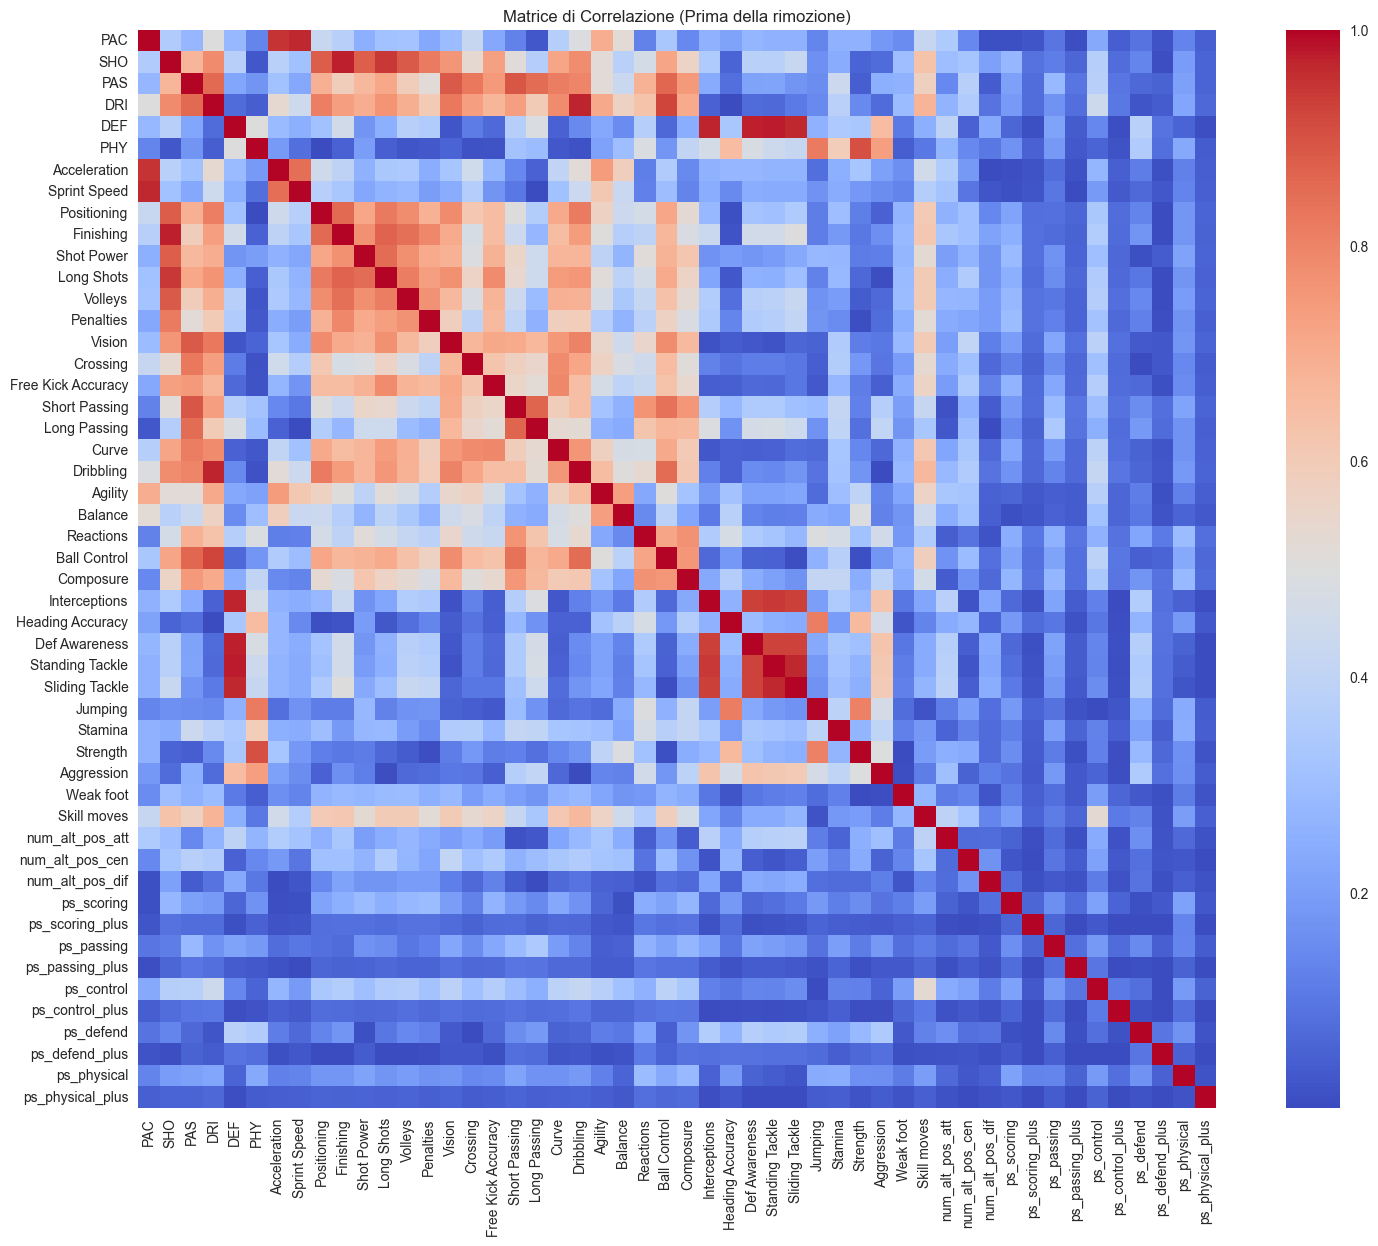


>>> SPIEGAZIONE FEATURE DROP:
Eliminiamo 11 feature perché hanno una correlazione > 90% con altre.
Esempi rimossi: ['Acceleration', 'Sprint Speed', 'Finishing', 'Long Shots', 'Dribbling']...


In [17]:
# --- SELEZIONE E PULIZIA FEATURE ---

# 1. Selezioniamo solo i numeri ed escludiamo colonne non tecniche (ID, Età, ecc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = [
    'ID', 'Jersey Number', 'Age', 'OVR', 'Potential', 'Special', 
    'International Reputation', 'Weak Foot', 'Skill Moves', 'Kit Number'
]
features_to_use = [col for col in numeric_cols if col not in cols_to_exclude]

# Creiamo il dataset temporaneo per l'analisi
X_temp = df[features_to_use].fillna(df[features_to_use].mean())

# 2. Calcolo della Matrice di Correlazione
corr_matrix = X_temp.corr().abs()

# --- VISUALIZZAZIONE (RICHIESTA) ---
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, xticklabels=True, yticklabels=True)
plt.title('Matrice di Correlazione (Prima della rimozione)')
plt.show()

# 3. Rimozione automatica feature ridondanti (Correlazione > 90%)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"\n>>> SPIEGAZIONE FEATURE DROP:")
print(f"Eliminiamo {len(to_drop)} feature perché hanno una correlazione > 90% con altre.")
print(f"Esempi rimossi: {to_drop[:5]}...")

# Lista finale feature pulite
final_features = [f for f in features_to_use if f not in to_drop]

### Cella 3: Filtro "Top Players" e PCA

In [9]:
# --- PREPROCESSING E PCA ---

# 1. Filtro Top Players (OVR >= 75)
# Necessario per avere ruoli ben definiti e densità più chiare
soglia_ovr = 75
df_top = df[df['OVR'] >= soglia_ovr].copy()
X_top = df_top[final_features].fillna(df_top[final_features].mean())

print(f"Analisi focalizzata su {len(df_top)} Top Players (OVR >= {soglia_ovr}).")

# 2. Standardizzazione (Scaling) - Fondamentale per DBSCAN!
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)

# 3. PCA a 3 Componenti
pca = PCA(n_components=3)
X_top_pca = pca.fit_transform(X_top_scaled)

# --- SPIEGAZIONE PCA (RICHIESTA) ---
print("\n>>> SPIEGAZIONE COMPONENTI PCA (Cosa significano i 3 assi?):")
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3'], 
    index=final_features
)

for i in range(1, 4):
    col = f'PC{i}'
    top_features = loadings[col].abs().sort_values(ascending=False).head(4).index.tolist()
    print(f"{col} è influenzata principalmente da: {top_features}")

# Visualizzazione 2D preliminare dello spazio
pca_df = pd.DataFrame(data=X_top_pca, columns=['PC1', 'PC2', 'PC3'])

Analisi focalizzata su 2086 Top Players (OVR >= 75).

>>> SPIEGAZIONE COMPONENTI PCA (Cosa significano i 3 assi?):
PC1 è influenzata principalmente da: ['DRI', 'SHO', 'Positioning', 'Curve']
PC2 è influenzata principalmente da: ['Long Passing', 'DEF', 'Short Passing', 'Aggression']
PC3 è influenzata principalmente da: ['Jumping', 'Heading Accuracy', 'PHY', 'Long Passing']


### Cella 4: Tuning dei Parametri (Grid Search)

In [10]:
# --- GRID SEARCH PER PARAMETRI OTTIMALI ---

print("Avvio ricerca parametri ottimali per DBSCAN...")

# Definiamo range di ricerca (basati sull'esperienza con dati PCA standardizzati)
eps_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5]
min_samples_values = [10, 15, 20, 25, 30]

best_score = -1
best_cfg = None
results = []

for eps in eps_values:
    for ms in min_samples_values:
        # Eseguiamo DBSCAN
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_top_pca)
        
        # Ignoriamo i casi in cui trova solo 1 cluster o solo rumore
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Calcoliamo score solo se ha senso (almeno 2 cluster reali)
            if n_clusters > 1:
                score = silhouette_score(X_top_pca, labels)
                results.append([eps, ms, n_clusters, n_noise, score])
                
                if score > best_score:
                    best_score = score
                    best_cfg = (eps, ms)

# Creiamo un dataframe dei risultati per vederli
res_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise', 'score'])
res_df = res_df.sort_values(by='score', ascending=False)

print("\n>>> MIGLIORI CONFIGURAZIONI TROVATE:")
display(res_df.head(5))

print(f"\nParametri scelti: eps={best_cfg[0]}, min_samples={best_cfg[1]} (Score: {best_score:.4f})")

Avvio ricerca parametri ottimali per DBSCAN...

>>> MIGLIORI CONFIGURAZIONI TROVATE:


,eps,min_samples,n_clusters,n_noise,score
14,0.9,25,2,1015,0.000442
13,0.9,15,2,530,-0.006801
16,1.0,20,2,486,-0.017894
9,0.8,15,2,863,-0.047226
8,0.8,10,3,474,-0.050704



Parametri scelti: eps=0.9, min_samples=25 (Score: 0.0004)


### Cella 5: Esecuzione Finale e Visualizzazione

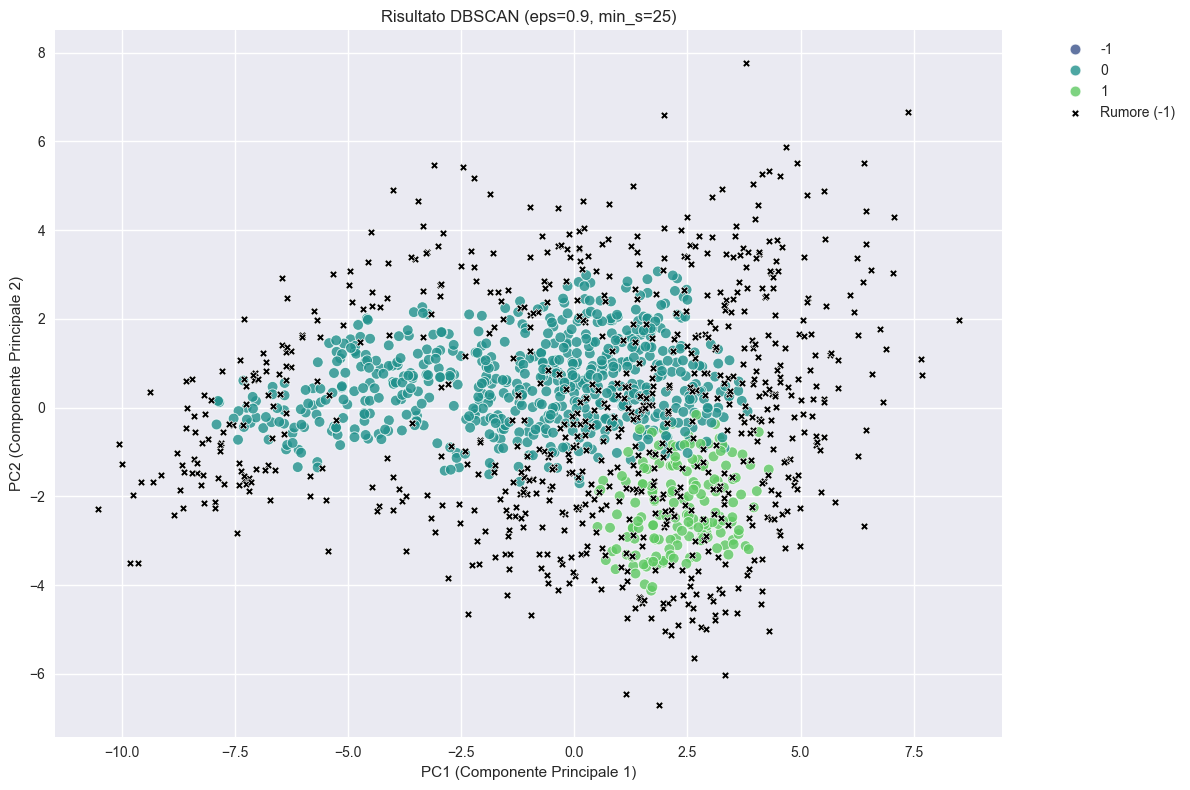

In [11]:
# --- ESECUZIONE E VISUALIZZAZIONE ---

# Applichiamo la configurazione migliore
best_eps, best_min_samples = best_cfg
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df_top['Cluster_DBSCAN'] = dbscan_final.fit_predict(X_top_pca)

# Prepariamo i dati per il grafico
plot_df = pca_df.copy()
plot_df['Cluster'] = df_top['Cluster_DBSCAN'].astype('category')

# Separiamo rumore e cluster per disegnarli diversamente
mask_noise = plot_df['Cluster'] == -1
df_noise = plot_df[mask_noise]
df_clusters = plot_df[~mask_noise]

# Plot
plt.figure(figsize=(12, 8))

# 1. Disegniamo i cluster validi
sns.scatterplot(
    data=df_clusters, x='PC1', y='PC2', hue='Cluster', 
    palette='viridis', s=60, alpha=0.8
)

# 2. Disegniamo il rumore (Nero, punti più piccoli o croci)
if not df_noise.empty:
    sns.scatterplot(
        data=df_noise, x='PC1', y='PC2', color='black', 
        s=30, marker='X', label='Rumore (-1)'
    )

plt.title(f'Risultato DBSCAN (eps={best_eps}, min_s={best_min_samples})')
plt.xlabel('PC1 (Componente Principale 1)')
plt.ylabel('PC2 (Componente Principale 2)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Cella 6: Spiegazione Finale dei Cluster

In [14]:
# --- SPIEGAZIONE FINALE DEI CLUSTER ---

print(f"\n>>> ANALISI TATTICA: CHI C'È NEI GRUPPI?")
print("Righe: Cluster Trovati da DBSCAN (-1 è il Rumore)")
print("Colonne: Ruoli Reali (Position)")

# Tabella di contingenza
ct = pd.crosstab(df_top['Cluster_DBSCAN'], df_top['Position'])
display(ct)

# Funzione per vedere esempi (nomi reali)
def mostra_esempi(cluster_id):
    print(f"\n--- Esempi di giocatori nel Cluster {cluster_id} ---")
    cols_show = ['Name', 'Position', 'OVR']
    try:
        esempi = df_top[df_top['Cluster_DBSCAN'] == cluster_id].sample(5)[cols_show]
        display(esempi)
    except ValueError:
        print("(Meno di 5 giocatori in questo cluster)")

# Mostriamo esempi per i cluster principali (e per il rumore se vuoi)
cluster_ids = sorted(df_top['Cluster_DBSCAN'].unique())
for c in cluster_ids:
    mostra_esempi(c)


>>> ANALISI TATTICA: CHI C'È NEI GRUPPI?
Righe: Cluster Trovati da DBSCAN (-1 è il Rumore)
Colonne: Ruoli Reali (Position)


Position,CAM,CB,CDM,CM,LB,LM,LW,RB,RM,RW,ST
Cluster_DBSCAN,,,,,,,,,,,
-1,94,204,72,109,31,72,38,40,55,38,262
0,43,216,136,184,107,13,8,118,15,4,3
1,23,0,0,0,0,38,24,1,52,35,51



--- Esempi di giocatori nel Cluster -1 ---


,Name,Position,OVR
1139,Vitor Roque,ST,76
608,Fran García,LB,78
147,Willi Orban,CB,83
1018,Bryan Gil,LM,76
14468,Kenza Dali,CM,82



--- Esempi di giocatori nel Cluster 0 ---


,Name,Position,OVR
14566,Tatiana Pinto,CM,80
14537,Sjoeke Nüsken,CM,81
398,Hamari Traoré,RB,80
868,Kalvin Phillips,CDM,77
766,Craig Dawson,CB,77



--- Esempi di giocatori nel Cluster 1 ---


,Name,Position,OVR
1495,Alan Velasco,LM,75
956,Sheraldo Becker,ST,76
538,Edin Višća,RM,79
14827,Macarena Portales,LW,76
1243,Edwuin Cetré,LM,75
